## 1. Setup & Config

In [ ]:
import random
from dataclasses import dataclass, asdict
from typing import List, Dict, Optional

# ---------- config ----------
config = {
    "episode_base_name": "Monday_11AM",
    "num_classrooms": 6,
    "attendance": [60, 45, 20, 80, 35, 50],
    "bottleneck": {
        "capacity_per_minute": 40,
        "batch_duration_min": 2
    },
    # Initial slots = 0 for all students
    # Offsets used only during negotiation
    "time_offsets": [0, -2, 2, -4, 4, -6, 6],
    "max_negotiation_rounds": 5,
    "violation_threshold": 3,
    "random_seed": 42
}

random.seed(config["random_seed"])


## 2. Define Message Schemas

In [ ]:
@dataclass
class Offer:
    offer_id: str
    proposer: str
    acceptor: str
    old_offset: int
    shift_min: int
    moved_students: int
    episode_created: int

@dataclass
class Commitment:
    commitment_id: str
    proposer: str   # owes
    acceptor: str   # is owed
    shift_min: int
    moved_students: int
    created_episode: int
    due_episode: int
    fulfilled: bool = False
    fulfilled_episode: Optional[int] = None
    times_missed: int = 0


## 3. Bottleneck Agent

In [ ]:
class BottleneckAgent:
    def __init__(self, cfg):
        self.cap_per_min = cfg["bottleneck"]["capacity_per_minute"]
        self.batch_duration = cfg["bottleneck"]["batch_duration_min"]
        self.per_batch = self.cap_per_min * self.batch_duration

    def broadcast_capacity(self, attendance_list, episode_tag):
        total_estimate = sum(attendance_list)
        msg = {"cap_per_min": self.cap_per_min, "total_estimate": total_estimate, "episode_tag": episode_tag}
        print(f"[B] broadcast: per_batch_capacity = {self.per_batch}, total_est={total_estimate}")
        return msg


## 4. Classroom Agent

In [ ]:
class ClassroomAgent:
    def __init__(self, id_, attendance, cfg, professor_willingness=0.7):
        self.id = id_
        self.attendance = attendance
        self.cfg = cfg
        self.professor_willingness = professor_willingness
        self.reputation = 1.0
        self.is_stubborn = False
        self.commitment_history: List[Commitment] = []
        # planned_slots stores (offset, students)
        self.planned_slots: List[tuple] = []
        self.per_batch = self.cfg["bottleneck"]["capacity_per_minute"] * self.cfg["bottleneck"]["batch_duration_min"]

    def on_capacity_broadcast(self, msg, index=0):
        self.per_batch = msg["cap_per_min"] * self.cfg["bottleneck"]["batch_duration_min"]
        # INITIAL slots = 0
        self.planned_slots = [(0, self.attendance)]

    def broadcast_schedule(self):
        return {"id": self.id, "slots": list(self.planned_slots)}

    def propose_shift(self, target_agent, congested_offset, current_episode, slot_map: Dict[int, int]):
        best_slot = None
        min_load = float('inf')
        for offset in self.cfg["time_offsets"]:
            if offset == congested_offset:
                continue  # Don't propose shifting to the same slot
            load = slot_map.get(offset, 0)
            if load < min_load:
                min_load = load
                best_slot = offset
        if best_slot is None:
            return None  # No valid slot found to make a proposal
        offer_amount = 0
        for off, cnt in self.planned_slots:
            if off == congested_offset:
                offer_amount = min(cnt, self.per_batch)
                break
        if offer_amount <= 0:
            return None
        offer = Offer(
            offer_id=f"offer_{self.id}_to_{target_agent.id}_ep{current_episode}",
            proposer=self.id,
            acceptor=target_agent.id,
            old_offset=congested_offset,
            shift_min=best_slot - congested_offset,  # DYNAMICALLY calculated shift
            moved_students=offer_amount,
            episode_created=current_episode
        )
        return offer

    def apply_offer(self, offer: Offer):
        old = offer.old_offset
        new = old + offer.shift_min
        moved = offer.moved_students
        updated = False
        new_slots = []
        for off, cnt in self.planned_slots:
            if off == old and not updated:
                move_count = min(cnt, moved)
                remaining = cnt - move_count
                if remaining > 0:
                    new_slots.append((off, remaining))
                moved -= move_count
                updated = True
            else:
                new_slots.append((off, cnt))
        if offer.moved_students - moved > 0:
            # merge into new slot
            merged = []
            found = False
            for off, cnt in new_slots:
                if off == new:
                    merged.append((off, cnt + (offer.moved_students - moved)))
                    found = True
                else:
                    merged.append((off, cnt))
            if not found:
                merged.append((new, offer.moved_students - moved))
            self.planned_slots = merged
        else:
            self.planned_slots = new_slots


In [ ]:
class ClassroomAgent(ClassroomAgent):  # extending previous definition
    def reduce_load_for_fulfillment(self, amount, forbidden_offset, slot_map: Dict[int, int], B_agent, agents_by_id):
        if self.is_stubborn:
            return False
        offsets = [0, -2, 2, -4, 4, -6, 6]  # offsets used for staggered shifting
        for src_index, (src_off, src_cnt) in enumerate(list(self.planned_slots)):
            if src_off == forbidden_offset or src_cnt <= 0:
                continue
            can_take = min(src_cnt, amount)
            for tgt in offsets:
                if tgt == forbidden_offset or tgt == src_off:
                    continue
                if slot_map.get(tgt, 0) + can_take <= B_agent.per_batch:
                    # reduce source
                    self.planned_slots[src_index] = (src_off, src_cnt - can_take)
                    # add to target
                    merged = []
                    added = False
                    for off, cnt in self.planned_slots:
                        if off == tgt:
                            merged.append((off, cnt + can_take))
                            added = True
                        else:
                            merged.append((off, cnt))
                    if not added:
                        merged.append((tgt, can_take))
                    # remove zeros
                    self.planned_slots = [(o,c) for o,c in merged if c>0]
                    slot_map[src_off] = slot_map.get(src_off,0) - can_take
                    slot_map[tgt] = slot_map.get(tgt,0) + can_take
                    return True
        return False

    def fulfill_due_commitments(self, commitments_global: List[Commitment], current_episode: int, slot_map: Dict[int,int],
                                B_agent, agents_by_id: Dict[str, "ClassroomAgent"], violation_threshold: int):
        for com in commitments_global:
            if com.proposer != self.id or com.due_episode != current_episode or com.fulfilled:
                continue
            acceptor_agent = agents_by_id[com.acceptor]
            if len(acceptor_agent.planned_slots) == 0:
                continue
            # target slot for acceptor
            target_slot = acceptor_agent.planned_slots[0][0] + abs(com.shift_min)
            available = B_agent.per_batch - slot_map.get(target_slot, 0)
            to_give = min(com.moved_students, max(0, available))
            if to_give <= 0:
                success = self.reduce_load_for_fulfillment(com.moved_students, forbidden_offset=target_slot,
                                                          slot_map=slot_map, B_agent=B_agent, agents_by_id=agents_by_id)
                if success:
                    available = B_agent.per_batch - slot_map.get(target_slot, 0)
                    to_give = min(com.moved_students, max(0, available))
                else:
                    com.times_missed += 1
                    print(f"[FULFILL FAILED] {self.id} couldn't fulfill {com.commitment_id} (missed {com.times_missed})")
                    if com.times_missed >= violation_threshold:
                        print(f"[VIOLATION] {self.id} exceeded violation threshold for {com.commitment_id}")
                        self.reputation *= 0.8
                    continue
            if to_give > 0:
                freed = self.reduce_load_for_fulfillment(to_give, forbidden_offset=target_slot, slot_map=slot_map,
                                                         B_agent=B_agent, agents_by_id=agents_by_id)
                if freed:
                    merged = []
                    added = False
                    for off, cnt in acceptor_agent.planned_slots:
                        if off == target_slot:
                            merged.append((off, cnt + to_give))
                            added = True
                        else:
                            merged.append((off, cnt))
                    if not added:
                        merged.append((target_slot, to_give))
                    acceptor_agent.planned_slots = merged
                    slot_map[target_slot] = slot_map.get(target_slot,0) + to_give
                    com.fulfilled = True
                    com.fulfilled_episode = current_episode
                    print(f"[FULFILLED] {self.id} fulfilled {com.commitment_id} by giving {to_give} to {acceptor_agent.id} at slot {target_slot}")
                else:
                    com.times_missed += 1
                    print(f"[FULFILL PARTIAL/FAIL] {self.id} couldn't free enough for {com.commitment_id} (missed {com.times_missed})")


In [ ]:
def compute_slot_map(classrooms: List[ClassroomAgent]) -> Dict[int,int]:
    slot_map = {}
    for c in classrooms:
        for off, cnt in c.planned_slots:
            slot_map[off] = slot_map.get(off, 0) + cnt
    return slot_map


In [ ]:
# Bottleneck
B = BottleneckAgent(config)

# Classrooms
classrooms = [ClassroomAgent(f"C{i+1}", config["attendance"][i], config) for i in range(config["num_classrooms"])]
agents_by_id = {c.id: c for c in classrooms}

classrooms[3].is_stubborn = True # Make C4 stubborn
print("System Config: Agent C4 is now 'stubborn' and will not fulfill commitments.")

# Global commitments ledger (persists across episodes)
commitments_global: List[Commitment] = []


System Config: Agent C4 is now 'stubborn' and will not fulfill commitments.


##  NEGOTIATION SIMULATION

In [ ]:
def run_simulation(num_episodes):
    for ep in range(1, num_episodes+1):
        ep_tag = f"{config['episode_base_name']}_ep{ep}"
        print("\n" + "="*40)
        print(f"RUNNING EPISODE {ep} ({ep_tag})")

        # 1) Broadcast capacity, initial slot assignment = 0
        msg = B.broadcast_capacity(config["attendance"], ep_tag)
        for c in classrooms:
            c.on_capacity_broadcast(msg)

        slot_map = compute_slot_map(classrooms)
        print("[Initial slot map]", slot_map)

        # 2) Fulfill carry-over commitments
        for c in classrooms:
            c.fulfill_due_commitments(commitments_global, current_episode=ep,
                                      slot_map=slot_map, B_agent=B, agents_by_id=agents_by_id,
                                      violation_threshold=config["violation_threshold"])
        slot_map = compute_slot_map(classrooms)
        print("[After fulfill attempts] slot_map:", slot_map)

        # 3) Negotiation rounds
        for round_ in range(config["max_negotiation_rounds"]):
            slot_map = compute_slot_map(classrooms)
            congested_offsets = [off for off, val in slot_map.items() if val > B.per_batch]
            if not congested_offsets:
                print(f"No congestion after negotiation round {round_} in episode {ep}")
                break
            print(f"[Negotiation round {round_}] congested offsets: {congested_offsets}")
            for off in congested_offsets:
                congested_agents = [c for c in classrooms if any(s[0]==off for s in c.planned_slots)]
                if len(congested_agents) < 2:
                    continue
                congested_agents.sort(key=lambda agent: next((s[1] for s in agent.planned_slots if s[0] == off), 0), reverse=True)

                a1 = congested_agents[0]
                a2 = congested_agents[1]

                print(f"[{a1.id}] (most students) is proposing to [{a2.id}].")

                # REPUTATION CHECK
                if a2.reputation < 0.5:
                    print(f"[{a1.id}] refuses to negotiate with {a2.id} due to low reputation ({a2.reputation:.2f}).")
                    continue # a1 skips a2 and the loop continues
                offer = a1.propose_shift(a2, off, ep, slot_map)
                if offer:
                    if random.random() < a2.professor_willingness:
                        print(f"{a1.id} proposes to {a2.id}: shift by {offer.shift_min} min, accepted.")
                        a2.apply_offer(offer)
                        com = Commitment(
                            commitment_id=f"com_{offer.offer_id}",
                            proposer=offer.proposer,
                            acceptor=offer.acceptor,
                            shift_min=offer.shift_min,
                            moved_students=offer.moved_students,
                            created_episode=ep,
                            due_episode=ep+1
                        )
                        commitments_global.append(com)
                        a1.commitment_history.append(com)
                        a2.commitment_history.append(com)
                        print(f"[COMMITTED] {com.commitment_id} created; due in episode {com.due_episode}")
                    else:
                        print(f"{a1.id} proposes to {a2.id}: shift by {offer.shift_min} min, REJECTED by {a2.id}.")

        slot_map = compute_slot_map(classrooms)
        print("[Final slot_map after episode]", slot_map)
        print("Schedules:")
        for c in classrooms:
            print(f" {c.id}: {c.planned_slots}")

# run 3 episodes
run_simulation(num_episodes=5)



RUNNING EPISODE 1 (Monday_11AM_ep1)
[B] broadcast: per_batch_capacity = 80, total_est=290
[Initial slot map] {0: 290}
[After fulfill attempts] slot_map: {0: 290}
[Negotiation round 0] congested offsets: [0]
[C4] (most students) is proposing to [C1].
C4 proposes to C1: shift by -2 min, accepted.
[COMMITTED] com_offer_C4_to_C1_ep1 created; due in episode 2
[Negotiation round 1] congested offsets: [0]
[C4] (most students) is proposing to [C6].
C4 proposes to C6: shift by 2 min, accepted.
[COMMITTED] com_offer_C4_to_C6_ep1 created; due in episode 2
[Negotiation round 2] congested offsets: [0]
[C4] (most students) is proposing to [C2].
C4 proposes to C2: shift by -4 min, accepted.
[COMMITTED] com_offer_C4_to_C2_ep1 created; due in episode 2
[Negotiation round 3] congested offsets: [0]
[C4] (most students) is proposing to [C5].
C4 proposes to C5: shift by 4 min, accepted.
[COMMITTED] com_offer_C4_to_C5_ep1 created; due in episode 2
[Negotiation round 4] congested offsets: [0]
[C4] (most stu

## Visualization

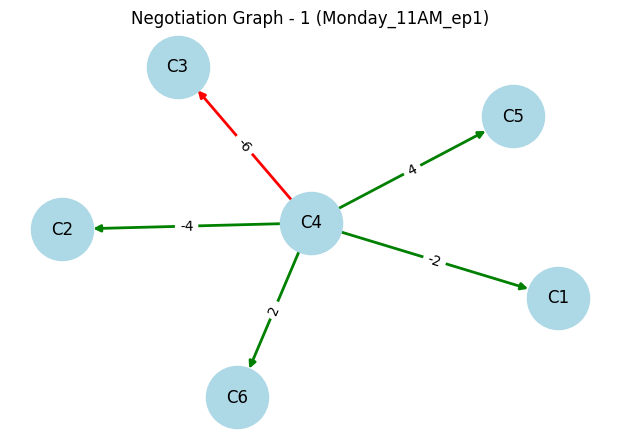

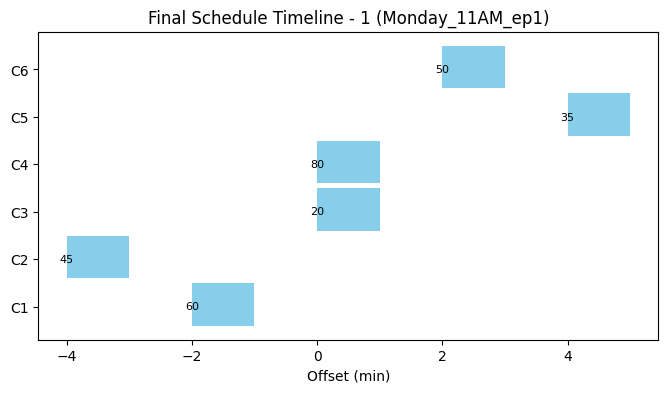

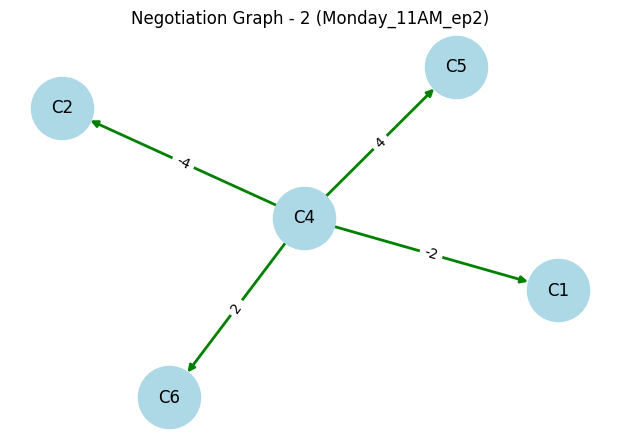

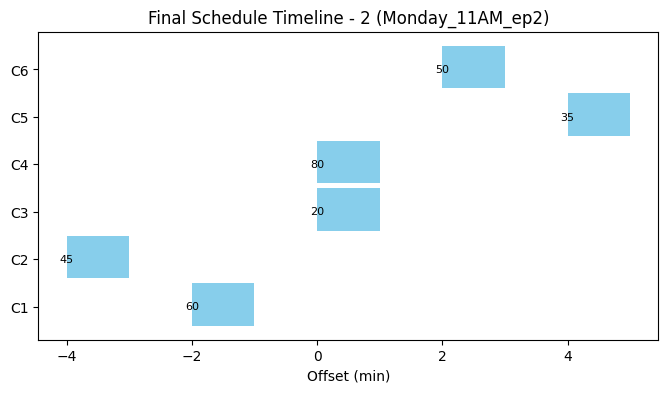

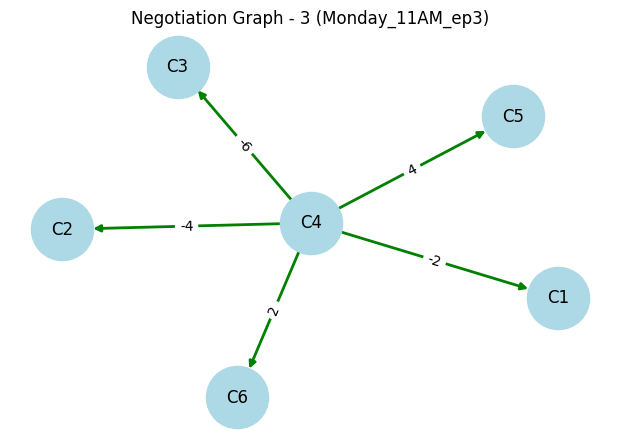

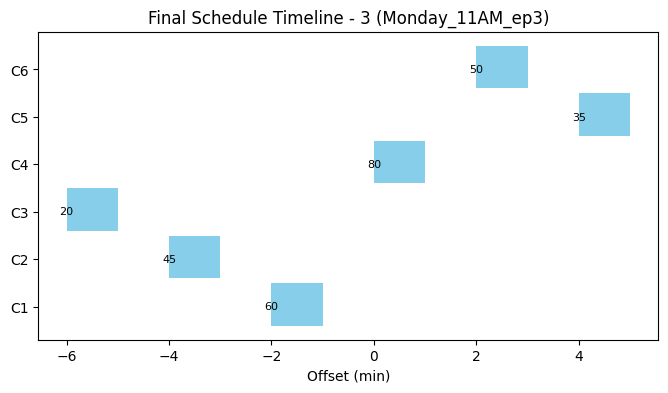

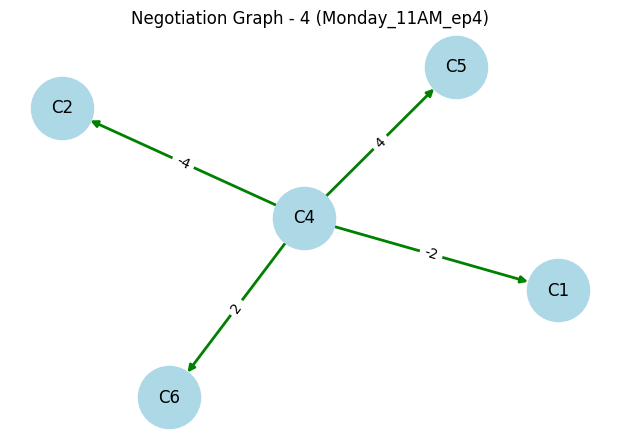

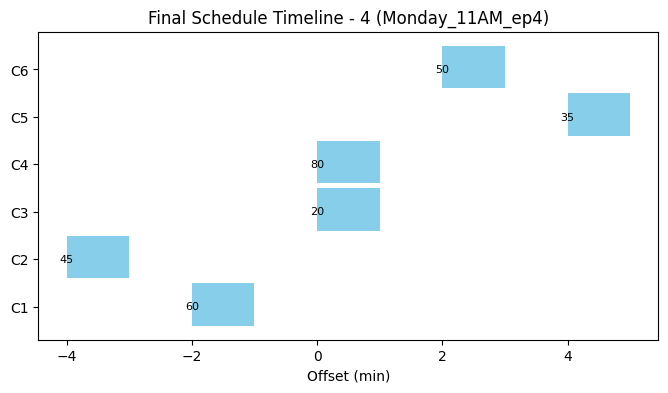

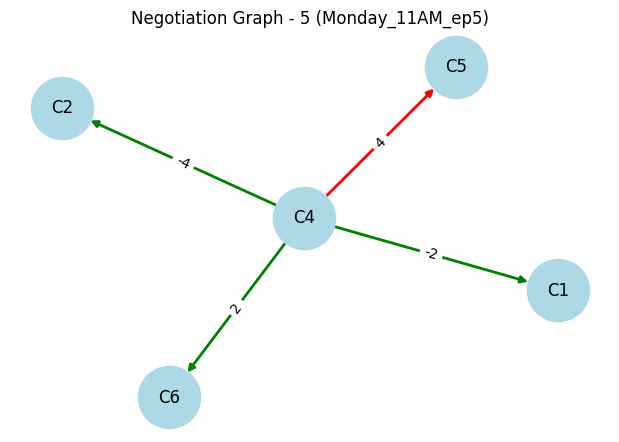

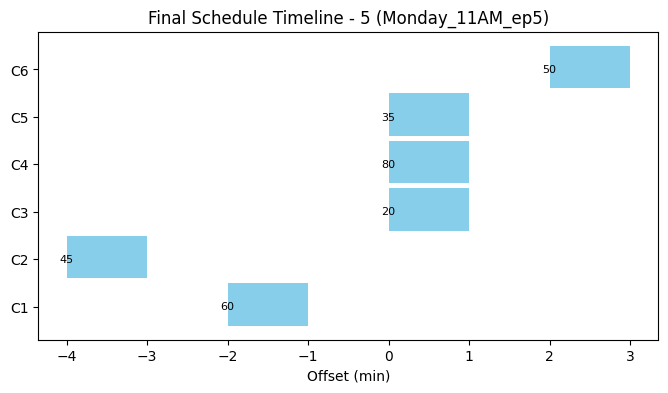

In [3]:
import re
import matplotlib.pyplot as plt
import networkx as nx

# === Step 1: Parse Logs into Structured Data ===
def parse_logs(log_text):
    episodes = []
    episode_blocks = log_text.strip().split("========================================")

    for block in episode_blocks:
        block = block.strip()
        if not block or not block.startswith("RUNNING EPISODE"):
            continue

        lines = block.splitlines()
        ep_name = lines[0].replace("RUNNING EPISODE ", "").strip()

        proposals = []
        schedules = {}

        # Regex patterns
        proposal_re = re.compile(r"(C\d+) proposes to (C\d+): shift by ([+-]?\d+) min, (accepted|REJECTED)", re.I)
        schedule_re = re.compile(r"(C\d+): \[\(([-]?\d+), (\d+)\)\]")

        for line in lines:
            m = proposal_re.search(line)
            if m:
                proposals.append({
                    "from": m.group(1),
                    "to": m.group(2),
                    "shift": int(m.group(3)),
                    "status": "accepted" if m.group(4).lower() == "accepted" else "rejected"
                })

            m2 = schedule_re.search(line)
            if m2:
                cls = m2.group(1)
                schedules.setdefault(cls, []).append((int(m2.group(2)), int(m2.group(3))))

        episodes.append({
            "name": ep_name,
            "proposals": proposals,
            "schedules": schedules
        })

    return episodes


# === Step 2: Visualization Functions ===
def plot_negotiation_graph(episode):
    G = nx.DiGraph()
    for p in episode["proposals"]:
        G.add_edge(p["from"], p["to"], shift=p["shift"], status=p["status"])

    pos = nx.spring_layout(G, seed=42)
    edge_colors = ["green" if G[u][v]["status"] == "accepted" else "red" for u, v in G.edges()]
    edge_labels = {(u, v): G[u][v]["shift"] for u, v in G.edges()}

    plt.figure(figsize=(6, 4))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue",
            edge_color=edge_colors, width=2, arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="black")
    plt.title(f"Negotiation Graph - {episode['name']}")
    plt.show()


def plot_schedule_timeline(episode):
    schedules = episode["schedules"]
    classrooms = sorted(schedules.keys())

    fig, ax = plt.subplots(figsize=(8, 4))

    yticks, ylabels = [], []
    for i, cls in enumerate(classrooms):
        for offset, size in schedules[cls]:
            ax.broken_barh([(offset, 1)], (i*10, 9), facecolors="skyblue")
            ax.text(offset, i*10+4, f"{size}", va="center", ha="center", fontsize=8)
        yticks.append(i*10+4)
        ylabels.append(cls)

    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_xlabel("Offset (min)")
    ax.set_title(f"Final Schedule Timeline - {episode['name']}")
    plt.show()


# === Step 3: Run ===
if __name__ == "__main__":
    # Paste your log string here
    with open("logs.txt", "r") as f:
        log_text = f.read()

    episodes = parse_logs(log_text)

    # Example: visualize first 2 episodes
    for ep in episodes[:5]:
        plot_negotiation_graph(ep)
        plot_schedule_timeline(ep)
